# Ac-225 Advanced PSF Modeling (SIMIND)

This tutorial uses the PSF operators obtained using the SPECTPSF toolbox to reconstruct Ac225 data. The operator was obtained using tutorial 5, available at this [link](https://github.com/lukepolson/SPECTPSFToolbox/blob/main/tutorials/5_optimization_ac225.ipynb). Use of this operator requires the SPECTPSFToolbox to be installed; instructions for installing can be found on the README [here](https://github.com/lukepolson/SPECTPSFToolbox/tree/main)

In [3]:
import os
import torch
import dill
import pytomography
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT  import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata, subsample_amap
from pytomography.likelihoods import PoissonLogLikelihood
import matplotlib.pyplot as plt

In [ ]:
path = '/disk1/pytomography_tutorial_data/ac225_tutorials/'

Load the SIMIND data. In this case, we'll use the ground truth scatter from SIMIND.

In [4]:
dT = 3.5 * 60 # seconds per projection
activity = 100 # mBq
CPSpMBq = 19.4796

# We only consider Bi213 here, since Fr221 doesnt contribute to this window
photopeak_path = os.path.join(path, 'bi213_phantom_data', 'tot_w8.h00')
scatter_path = os.path.join(path, 'bi213_phantom_data', 'sca_w8.h00')
amap = simind.get_attenuation_map(os.path.join(path, 'bi213_phantom_data', 'amap.hct'))
object_meta, proj_meta = simind.get_metadata(photopeak_path)
projectionss = simind.get_projections([photopeak_path, scatter_path])

The projection data is 96 angles and 256x256 here. The function below allows us to reduce the projections to 32 angles and 128x128 which corresponds to typical Ac225 acquisition.

In [5]:
object_meta, proj_meta, projectionss = subsample_projections_and_modify_metadata(object_meta, proj_meta, projectionss, N_pixel = 2, N_angle=4)
amap = subsample_amap(amap, N=2)

Get photopeak and scatter:

In [6]:
photopeak = torch.poisson(projectionss[0]*activity*dT)
scatter = torch.poisson(projectionss[1]*activity*dT)

The code below reconstructs using MLEM(30it,1ss)

In [7]:
def perform_reconstruction(psf_transform):
    att_transform = SPECTAttenuationTransform(attenuation_map=amap)
    system_matrix = SPECTSystemMatrix(
            obj2obj_transforms = [att_transform,psf_transform],
            proj2proj_transforms = [],
            object_meta = object_meta,
            proj_meta = proj_meta)
    likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter)
    algorithm = OSEM(likelihood)
    return algorithm(n_iters=30, n_subsets=1)

Reconstruct using the operator saved from SPECTPSFToolbox:

In [8]:
with open(os.path.join(path, 'ac225_tutorials', 'psf_operator_ac225.pkl'), 'rb') as f:
    psf_operator = dill.load(f)
psf_operator.set_device(pytomography.device)
psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
recon_1Dfit = perform_reconstruction(psf_transform)

Reconstruct using the Gaussian modeling which doesn't account for the septal penetration and septal scatter:

In [9]:
psf_meta = simind.get_psfmeta_from_header(photopeak_path)
psf_transform = SPECTPSFTransform(psf_meta)
reconbad = perform_reconstruction(psf_transform)

Lets compare the two reconstructions: the first one using the fitted PSF and the second one using the Monte Carlo kernels. Note that the fitted one was over twice as fast for reconstructing!

In [12]:
recons = [reconbad, recon_1Dfit]
titles = ['Gaussian PSF [GC Only]', 'Full PSF']

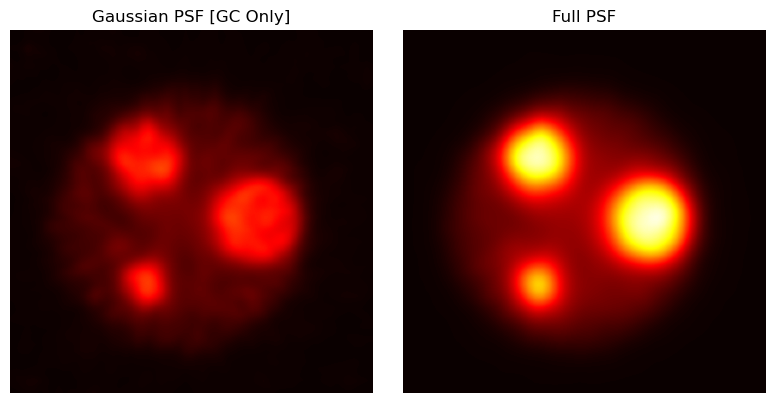

In [14]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
vmax = recons[1].max()
for i in range(2):
    plt.sca(ax[i])
    plt.imshow(recons[i].cpu().numpy()[:,:,64], cmap='hot', interpolation='gaussian', vmax=vmax)
    plt.title(titles[i])
    plt.axis('off')
    plt.xlim(35,95)
    plt.ylim(35,95)
fig.tight_layout()